In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [16]:
algo_map = {
    2: "cuBLAS",
    3: "cuSPARSE",
    7: "MACKO",
}

In [17]:
def load_results(gpu_name, bits=16):
    path = f"../c_benchmarking/results_{bits}bit/{gpu_name}/results.txt"
    df = pd.read_csv(path, sep="\t", skiprows=1, index_col=None, names=["","Bits per value", "Rows", "Cols", "Algorithm", "Density", "Runtime", "GFLOPS", "Sparse GFLOPS"])
    df.loc[df["Runtime"]==" ", "Runtime"] = None
    df["Runtime"] = df["Runtime"].astype(float)
    return df


In [18]:
def draw_speedup(df, gpu_name):
    gpu_name_nice = gpu_name.replace("_", " ")

    R, C = 2*4096, 2*4096
    for R, C in [[4096, 4096], [2*4096, 2*4096], [36864,12288]]:
        for_m = df.query(f"Rows=={R} and Cols=={C}").copy()
        cublas_runtime = for_m.query("Algorithm==2")["Runtime"].mean()
        for_m["Speedup over cuBLAS"] = cublas_runtime/for_m["Runtime"]
        for_m["Sparsity"] = (1-for_m["Density"]).round(2)
        for_m["Density"] = for_m["Density"]
        for_m["Algorithm"] = for_m["Algorithm"].map(algo_map)

        ax = sns.lineplot(data=for_m, x="Sparsity", y="Speedup over cuBLAS", hue="Algorithm")

        cublas_color = [line.get_color() for line in ax.lines if line.get_label().strip() == "cuBLAS"][0]

        for line in ax.lines:
            # Get the data of this line
            x_data = line.get_xdata()
            y_data = line.get_ydata()
            if line.get_color() == cublas_color:
                continue
            
            for x, y in zip(x_data, y_data):
                ax.text(
                    x, y,
                    f'{y:.2f}',          # format label
                    color="black",
                    fontsize=9,
                    ha='center',         # horizontal alignment
                    va='bottom'          # vertical alignment
                )

        plt.xticks([0.1*x for x in range(11)])
        plt.grid()
        title = f"{gpu_name_nice}, fp16, {R}x{C}, cuBLAS runtime {int(cublas_runtime)} $\\mu s$"
        plt.title(title)
        print(title)
        plt.savefig(f"../media/fp16_{gpu_name}_{R}_{C}_relative_speedup.svg")
        plt.savefig(f"../media/fp16_{gpu_name}_{R}_{C}_relative_speedup.png")

        plt.show()

In [19]:
def draw_speedup_over_all_sizes(df, gpu_name):
    gpu_name_nice = gpu_name.replace("_", " ")

    over_sizes = df.copy()
    speedups = []
    for i, row in over_sizes.iterrows():
        cublas_runtime = df.query(f"Rows=={row.Rows} and Cols=={row.Cols} and Density=={row.Density} and Algorithm==2")["Runtime"].mean()
        speedup = cublas_runtime/row.Runtime
        speedups.append(speedup)


    over_sizes["Algorithm"] = over_sizes["Algorithm"].map(algo_map)

    over_sizes["Sparsity"] = (1-over_sizes["Density"]).round(2)
    over_sizes["Speedup over cuBLAS"] = speedups
    sns.boxplot(data=over_sizes, x="Sparsity", y="Speedup over cuBLAS", hue="Algorithm", fill=False, gap=.1)

    plt.grid()
    title = f"{gpu_name_nice}, fp16"
    plt.title(title)
    plt.savefig(f"../media/{gpu_name}_relative_speedup_all_sizes.svg")
    plt.savefig(f"../media/{gpu_name}_relative_speedup_all_sizes.png")
    plt.show()

    for d in ["0.1", "0.5"]:
        df_d = over_sizes.query(f"Algorithm == 'MACKO' and Density=={d}")
        print(f"Density {d}")
        display(df_d[["Rows", "Cols", "Speedup over cuBLAS"]].describe())


NVIDIA GeForce RTX 3090, fp16, 4096x4096, cuBLAS runtime 54 $\mu s$


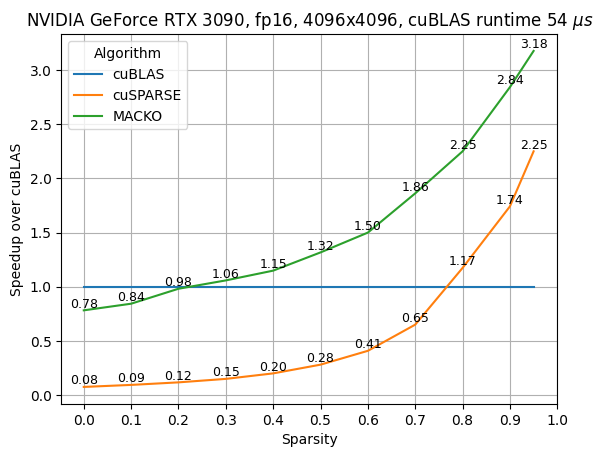

NVIDIA GeForce RTX 3090, fp16, 8192x8192, cuBLAS runtime 171 $\mu s$


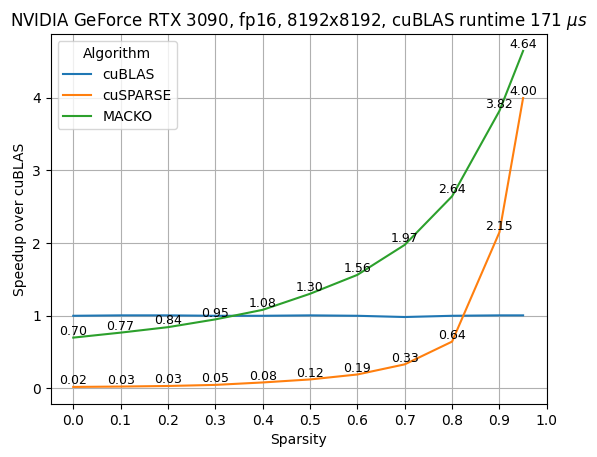

NVIDIA GeForce RTX 3090, fp16, 36864x12288, cuBLAS runtime 1136 $\mu s$


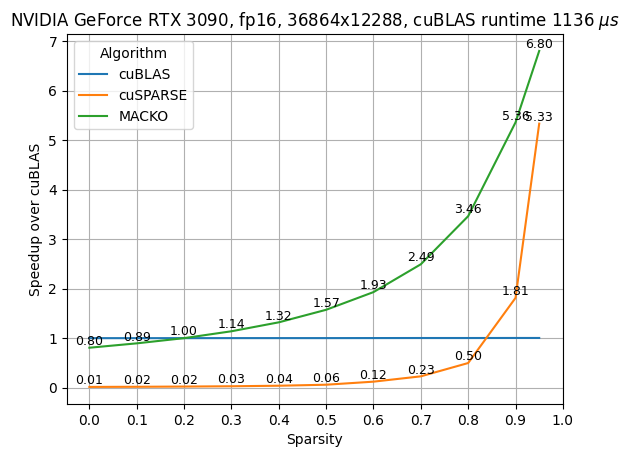

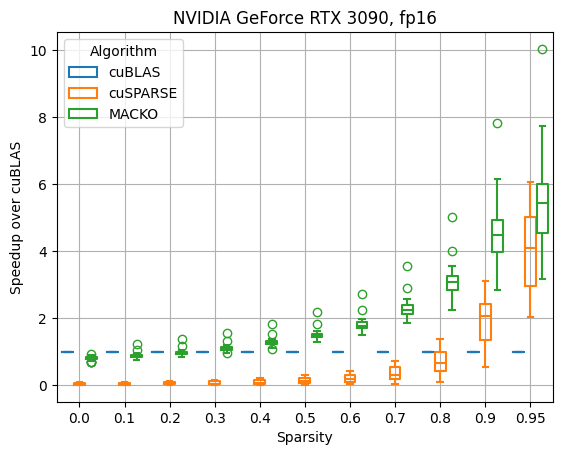

Density 0.1


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,4.509329
std,12519.679738,11009.633887,0.922362
min,3584.000000,3584.000000,2.842105
25%,7168.000000,5120.000000,3.958546
50%,12288.000000,9216.000000,4.472000
75%,28160.000000,14080.000000,4.933966
max,49152.000000,49152.000000,7.814961


Density 0.5


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.490779
std,12519.679738,11009.633887,0.166093
min,3584.000000,3584.000000,1.295455
25%,7168.000000,5120.000000,1.430252
50%,12288.000000,9216.000000,1.477273
75%,28160.000000,14080.000000,1.537600
max,49152.000000,49152.000000,2.176535


In [20]:
target_gpu = "NVIDIA_GeForce_RTX_3090"
df = load_results(target_gpu)
draw_speedup(df, target_gpu)
draw_speedup_over_all_sizes(df, target_gpu)

NVIDIA GeForce RTX 4090, fp16, 4096x4096, cuBLAS runtime 59 $\mu s$


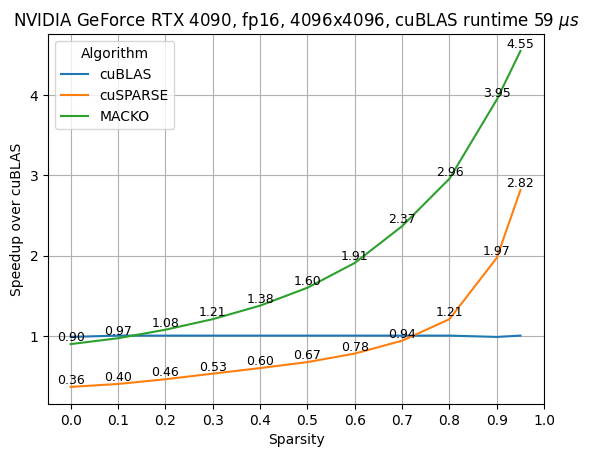

NVIDIA GeForce RTX 4090, fp16, 8192x8192, cuBLAS runtime 166 $\mu s$


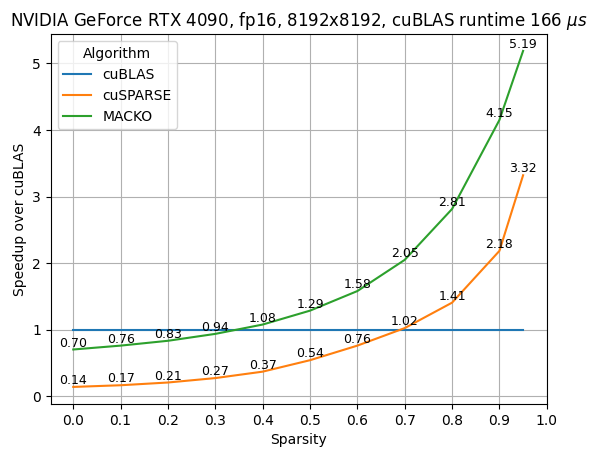

NVIDIA GeForce RTX 4090, fp16, 36864x12288, cuBLAS runtime 950 $\mu s$


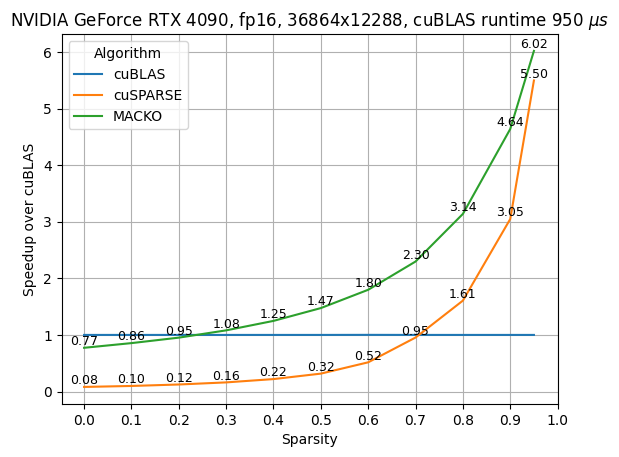

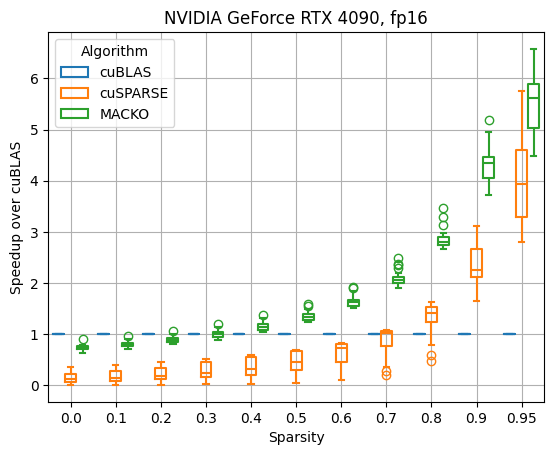

Density 0.1


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,4.307942
std,12519.679738,11009.633887,0.302822
min,3584.000000,3584.000000,3.727273
25%,7168.000000,5120.000000,4.053559
50%,12288.000000,9216.000000,4.339806
75%,28160.000000,14080.000000,4.457801
max,49152.000000,49152.000000,5.187500


Density 0.5


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.353817
std,12519.679738,11009.633887,0.090849
min,3584.000000,3584.000000,1.231707
25%,7168.000000,5120.000000,1.286889
50%,12288.000000,9216.000000,1.333333
75%,28160.000000,14080.000000,1.389436
max,49152.000000,49152.000000,1.594595


In [21]:
target_gpu = "NVIDIA_GeForce_RTX_4090"
df = load_results(target_gpu)
draw_speedup(df, target_gpu)
draw_speedup_over_all_sizes(df, target_gpu)

NVIDIA GeForce RTX 2080 SUPER, fp16, 4096x4096, cuBLAS runtime 86 $\mu s$


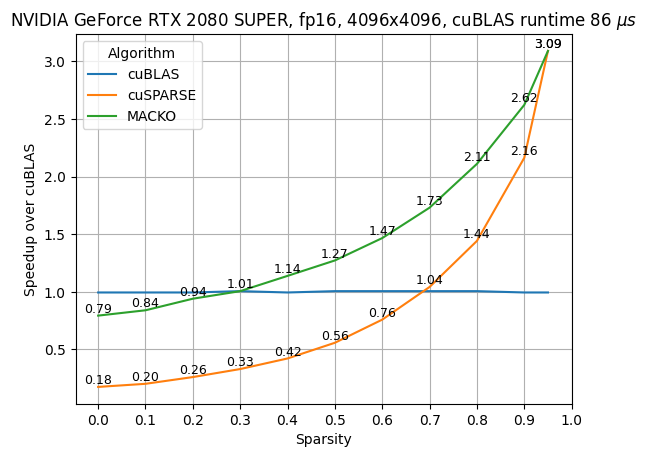

NVIDIA GeForce RTX 2080 SUPER, fp16, 8192x8192, cuBLAS runtime 325 $\mu s$


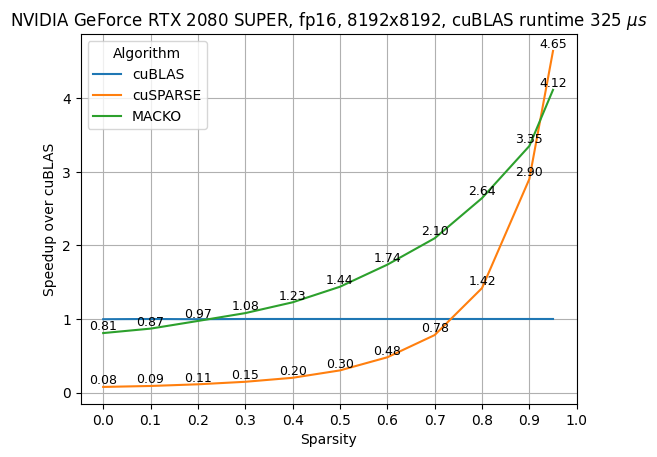

NVIDIA GeForce RTX 2080 SUPER, fp16, 36864x12288, cuBLAS runtime 2018 $\mu s$


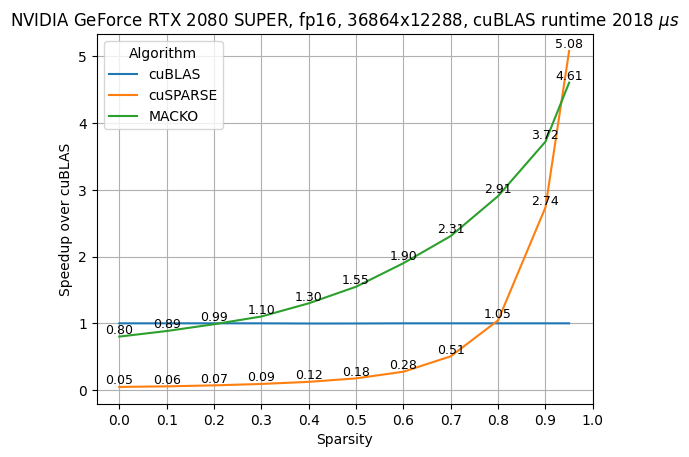

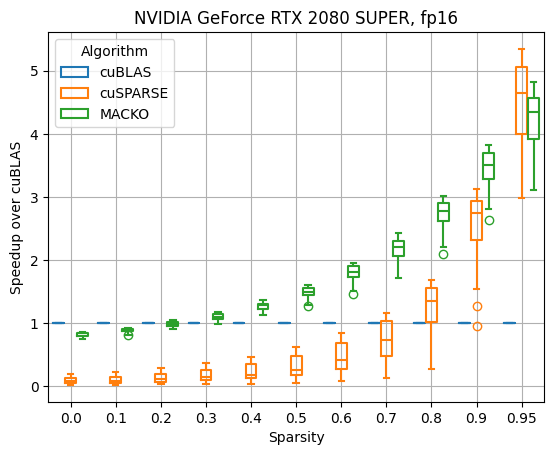

Density 0.1


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,3.437532
std,12519.679738,11009.633887,0.300251
min,3584.000000,3584.000000,2.636364
25%,7168.000000,5120.000000,3.289617
50%,12288.000000,9216.000000,3.506849
75%,28160.000000,14080.000000,3.693647
max,49152.000000,49152.000000,3.823383


Density 0.5


,Rows,Cols,Speedup over cuBLAS
count,31.000000,31.000000,31.000000
mean,16631.741935,12936.258065,1.480932
std,12519.679738,11009.633887,0.096345
min,3584.000000,3584.000000,1.264706
25%,7168.000000,5120.000000,1.441654
50%,12288.000000,9216.000000,1.494118
75%,28160.000000,14080.000000,1.554791
max,49152.000000,49152.000000,1.601810


In [22]:
target_gpu = "NVIDIA_GeForce_RTX_2080_SUPER"
df = load_results(target_gpu)
draw_speedup(df, target_gpu)
draw_speedup_over_all_sizes(df, target_gpu)